# Title

# Introduction: 

# Preliminary exploratory data analysis: 

In [1]:
### Run the R libraries 
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10) #This can only show 10 rows of the dataframe.



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names= FALSE)
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "disease_type")
cleveland_data <- mutate(cleveland_data, disease_type = as_factor(disease_type))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


Cleaning the data by using filter() functions:
We can see that there are "?" in ca colum and missing values in thal column. Our first step is to filter out the missing rows and "?" data.

In [3]:
filter_cleveland_data <- cleveland_data |>
    filter(thal != "?", ca != "?") |>
    drop_na()



In order to make a valid prediction, we need to ensure this data frame has a good balance between patients with heart disease and people without heart disease. We decided to make a plot to visualize it. By observing the disease_type, we see that there are 4 different types of heart disease and 0 represents that this patient does not have heart disease. Therefore, we start by mutating this column into a true/false of whether this patient has heart disease or not. We use a ifelse function to ask the question if the person have heart disease or not.

In [4]:
new_cleveland_data <- filter_cleveland_data |> mutate(have_heart_disease = ifelse(disease_type == 0, "No", "Yes"))
new_cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type,have_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,No
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,No
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1,Yes
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1,Yes
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2,Yes


Now we split our data into 2 sets, training set and testing set.

In [5]:
# Set the seed.
set.seed(3456) 

# Split the data into 75% and 25%.
data_split <- initial_split(new_cleveland_data, prop = 0.75, strata = have_heart_disease)  

heart_train_set <- training(data_split)   
heart_test_set <- testing(data_split)

here!!!!!!

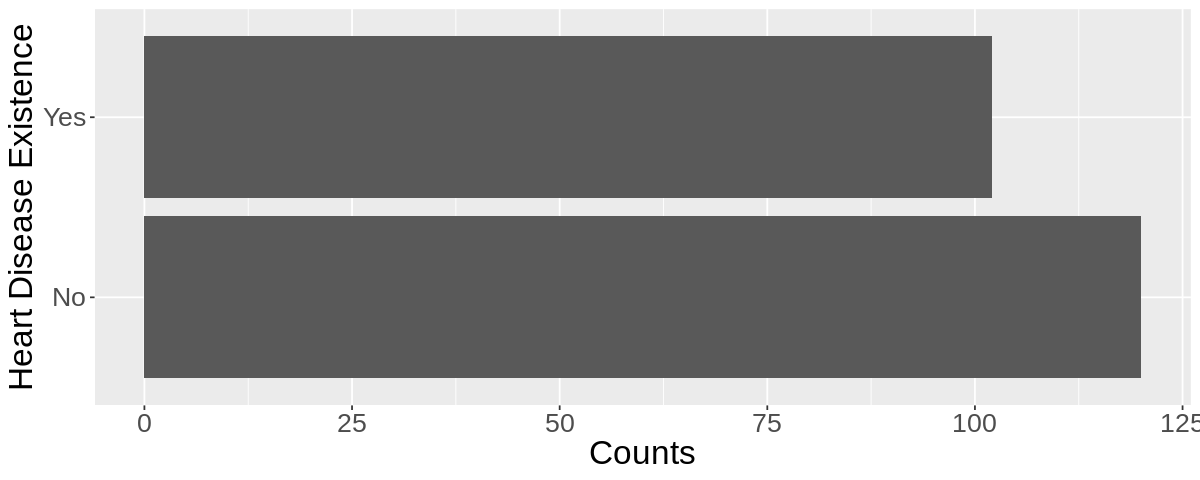

In [7]:
options(repr.plot.width = 10, repr.plot.height = 4)

counting_types <- heart_train_set |>
    group_by(have_heart_disease)|>
    summarize(types_count = n()) 

exsitance_plot<- counting_types |>
ggplot(aes( x = have_heart_disease,
            y = types_count)) +
    geom_bar(stat = 'identity') +
    coord_flip() +
    labs(x = "Heart Disease Existence", y = "Counts") +
    theme(text = element_text(size = 20))
exsitance_plot


# Methods: 

# Expected outcomes and significance: